# Twitter Hate Speech Analysis

According to data acquired from the Federal Bureau of Intelligence (FBI), hate speech and hate crimes have both been on the rise for the past few years. Studies documented on how to combat hateful idealogies are complicated and offer no easy answers. Further complicating the issue is that hate speech affects different groups differently and rises and drops on who it targets over the years. Since recent times have shown such a large surge in hateful idealogies, this project hopes to analyze current hate speech trends using Natural Language Processing (NLP), Data Analysis, and Machine Learning.

## Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Load Up Datasets

In [3]:
df_train = pd.read_csv('Data/hate_speech_training.csv')
df_train_2 = pd.read_csv('Data/hate_speech_training_2.csv')
df_train_3 = pd.read_csv('Data/hate_speech_training_3.csv')
df_train_4 = pd.read_csv('Data/hate_speech_training_4.tsv', sep = '\t')
df_train_5 = pd.read_csv('Data/hate_speech_training_5.csv')
df_test = pd.read_csv('Data/hate_speech_test.csv')

### Clean Up Datasets and Map Hate Speech to 1 and Non Hate Speech to 0

In [4]:
df_train = df_train.drop('id', axis = 1) #0 = Not Hate Speech, 1 = Hate Speech

In [5]:
df_train_2 = df_train_2[['tweet', 'class']]
df_train_2['class'] = df_train_2['class'].replace([0], 'hate speech')
df_train_2['class'] = df_train_2['class'].replace([1, 2], 'not hate speech')
df_train_2['class'] = df_train_2['class'].replace(['hate speech'], 1)
df_train_2['class'] = df_train_2['class'].replace(['not hate speech'], 0)
df_train_2.rename(columns = {'class': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [6]:
df_train_3 = df_train_3.drop('index', axis = 1) 
df_train_3.rename(columns = {'post': 'tweet'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [7]:
df_train_4 = df_train_4[['text', 'HS']] 
df_train_4.rename(columns = {'text': 'tweet', 'HS': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [8]:
df_train_5['Label'] = df_train_5['Label'].replace(['Hate', 'Non-Asian Aggression'], 1)
df_train_5['Label'] = df_train_5['Label'].replace(['Neutral', 'Counterhate'], 0) 
df_train_5.rename(columns = {'Text': 'tweet', 'Label': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

### Combine the 5 Training Sets Together

In [9]:
dfs = [df_train, df_train_2, df_train_3, df_train_4, df_train_5]
df = pd.concat(dfs)

## Initial Exploratory Analysis

### How Many Hate Tweets Do We Have vs. Non Hate Tweets?

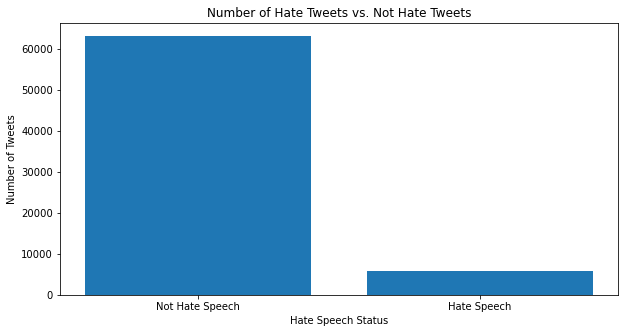

In [10]:
fig_1, ax_1 = plt.subplots(figsize = (10,5))

x = ['Not Hate Speech', 'Hate Speech']
y = df['label'].value_counts().values

ax_1.bar(x, y)
ax_1.set_title('Number of Hate Tweets vs. Not Hate Tweets')
ax_1.set_xlabel('Hate Speech Status')
ax_1.set_ylabel('Number of Tweets');

### Word Cloud for Labeled Hate Tweets

#### *WARNING! This Word Cloud Will Inevitable Contain Hateful and Offensive Language (including slurs for different protected classes). Please do not run these cells if you are unable to view that kind of language currently for any reason*

In [11]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [12]:
comment_words = ''
stopwords = list(STOPWORDS)
for word in df[df['label'] == 1]['tweet']:
    tokens = word.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "

In [13]:
stopwords.append('user')
stopwords.append('t')
stopwords.append('co')
stopwords.append('amp')

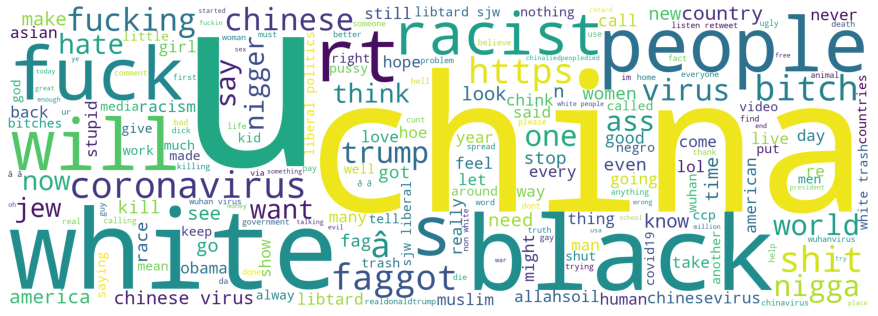

In [14]:
wordcloud = WordCloud(width = 2000, height = 700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (12, 12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

#### Unsurprisingly, China is one of the biggest terms which logically follows due to the current rise in Asian hate speech

### Is There A Difference In Statistically Significant Difference Between The Length Of Hate Tweets vs Not Hate Tweets?

In [15]:
df_len = df
df_len['length'] = df_len['tweet'].apply(len)

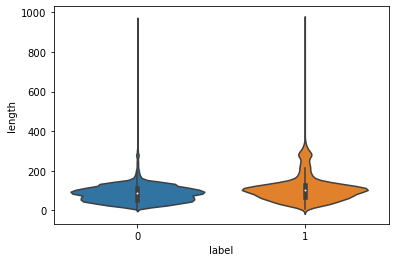

In [16]:
sns.violinplot(x = 'label', y = 'length', data = df_len); #1 = Hate Speech, #0 = Not Hate Speech

In [17]:
from scipy import stats
stats.ttest_ind(df_len[df_len['label'] == 1]['length'], df_len[df_len['label'] == 0]['length'])

Ttest_indResult(statistic=39.29300040893459, pvalue=0.0)

The p-value is less then your average alpha of 0.05 which means there is a statistically significant difference between the two groups. The violin plots show that hate tweets (on average) are longer then not hate tweets

### Let's See The Distribution & Mean of Tweet Characters For Hate Speech & Not Hate Speech

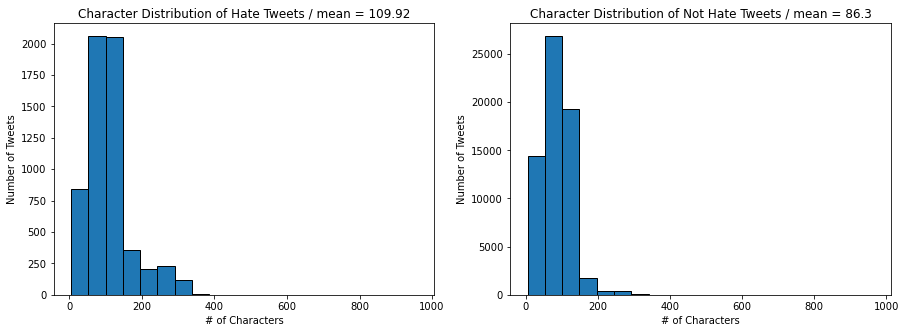

In [18]:
fig_2, ax_2 = plt.subplots(figsize = (15, 5), ncols = 2)

x_hate = df_len[df_len['label'] == 1]['length']
x_not_hate = df_len[df_len['label'] == 0]['length']

ax_2[0].hist(x_hate, bins = 20, edgecolor = 'black')
ax_2[0].set_title(f"Character Distribution of Hate Tweets / mean = {round(np.mean(x_hate), 2)}")
ax_2[0].set_xlabel('# of Characters')
ax_2[0].set_ylabel('Number of Tweets')

ax_2[1].hist(x_not_hate, bins = 20, edgecolor = 'black')
ax_2[1].set_title(f"Character Distribution of Not Hate Tweets / mean = {round(np.mean(x_not_hate), 2)}");
ax_2[1].set_xlabel('# of Characters')
ax_2[1].set_ylabel('Number of Tweets');

It seems that on average, hate tweets are about 24 characters longer then non-hate tweets

#### That's really it for basic EDA Analysis of our dataset, the next cell will show our NLP and modeling results. Grid searches were a big part of that process so the actual modeling and grid searches will take place on separate notebooks but you can see the results below

### Word Frequency Chart for All Tweets

In [277]:
import nltk
import string
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.probability import FreqDist
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [254]:
sw = stopwords.words('english')

In [255]:
sw_add = ['ð', '\x9f', '\x98', '\x80', '@user', '¦', '...', 'â', '\x92', '\x8f',
         'urð','\x93','±', '\x99', '\x8e', '\x91', '\x84', '\x91','2/2', '¯', '©',
         '\xad','\x86','\x9d','0.2','0.5','²', 'angryð', '\x90', '..', '80', '45.00',
         '. .', '75', '\x9c','\x88','\x8a','¤','ï','¸','50','1', '60', 'g','p', 'w','2',
         '’', '25', '2','\x8c','¼','Ã']

In [256]:
sw = sw + sw_add

In [274]:
word_list = []
tweet_token = TweetTokenizer()
for tweet in df['tweet'].values:
    words = tweet_token.tokenize(tweet)
    for word in words:
        word_list.append(word)

In [275]:
word_list

['@user',
 'when',
 'a',
 'father',
 'is',
 'dysfunctional',
 'and',
 'is',
 'so',
 'selfish',
 'he',
 'drags',
 'his',
 'kids',
 'into',
 'his',
 'dysfunction',
 '.',
 '#run',
 '@user',
 '@user',
 'thanks',
 'for',
 '#lyft',
 'credit',
 'i',
 "can't",
 'use',
 'cause',
 'they',
 "don't",
 'offer',
 'wheelchair',
 'vans',
 'in',
 'pdx',
 '.',
 '#disapointed',
 '#getthanked',
 'bihday',
 'your',
 'majesty',
 '#model',
 'i',
 'love',
 'u',
 'take',
 'with',
 'u',
 'all',
 'the',
 'time',
 'in',
 'urð',
 '\x9f',
 '\x93',
 '±',
 '!',
 '!',
 '!',
 'ð',
 '\x9f',
 '\x98',
 '\x99',
 'ð',
 '\x9f',
 '\x98',
 '\x8e',
 'ð',
 '\x9f',
 '\x91',
 '\x84',
 'ð',
 '\x9f',
 '\x91',
 'ð',
 '\x9f',
 '\x92',
 '¦',
 'ð',
 '\x9f',
 '\x92',
 '¦',
 'ð',
 '\x9f',
 '\x92',
 '¦',
 'factsguide',
 ':',
 'society',
 'now',
 '#motivation',
 '[',
 '2/2',
 ']',
 'huge',
 'fan',
 'fare',
 'and',
 'big',
 'talking',
 'before',
 'they',
 'leave',
 '.',
 'chaos',
 'and',
 'pay',
 'disputes',
 'when',
 'they',
 'get',
 'there

In [ ]:
"([a-zA-Z]+(?:'[a-z]+)?)" #takes only characters that are words, no numbers

In [280]:
tfidf = TfidfVectorizer(token_pattern = "([a-zA-Z]+(?:'[a-z]+)?)")

In [282]:
exp = tfidf.fit_transform(df['tweet'].values)

In [285]:
tfidf.get_feature_names()

['a',
 "a's",
 "a'shanni",
 "a'z",
 'aa',
 'aaa',
 'aaaaa',
 'aaaaaaaaahhhhhhh',
 'aaaaaaaaand',
 'aaaaaand',
 'aaaaah',
 'aaaaand',
 'aaadontplayy',
 'aaahh',
 'aaahhhh',
 'aaahhhhh',
 'aaand',
 'aaawwwww',
 'aaberg',
 'aaccstatement',
 'aadityaji',
 'aah',
 'aahahah',
 'aaiv',
 'aajtak',
 "aaka's",
 'aakhri',
 'aakwohdfgv',
 'aakxwife',
 'aal',
 'aalivyahsimon',
 'aaliyah',
 'aaliyahh',
 'aaliyahhhm',
 'aamaadmiparty',
 'aamaadmipay',
 'aameer',
 'aamirkhan',
 'aamjhhow',
 'aamu',
 'aan',
 'aande',
 'aangirfan',
 'aanpsujmyi',
 'aap',
 "aap's",
 'aapi',
 'aapia',
 'aaptards',
 'aarakshan',
 'aarhus',
 'aaron',
 'aaronbaxter',
 'aaroncarter',
 'aaronkeplin',
 'aaronmacgruder',
 'aaronorentas',
 'aaronrhodes',
 'aaronthegoat',
 'aaronworthing',
 'aarya',
 'aaryn',
 'aaryneliza',
 'aarynelizagries',
 'aascf',
 'aasthaxoxo',
 'aayat',
 'aaymee',
 'aayrrknbt',
 'ab',
 'aba',
 'abadbitchcost',
 'abaesq',
 'abam',
 'abandon',
 'abandonado',
 'abandoned',
 'abandons',
 'abantu',
 'abartick',

In [258]:
word_list = [word for word in word_list if word not in sw]
word_list = [word for word in word_list if word not in list(string.punctuation)]

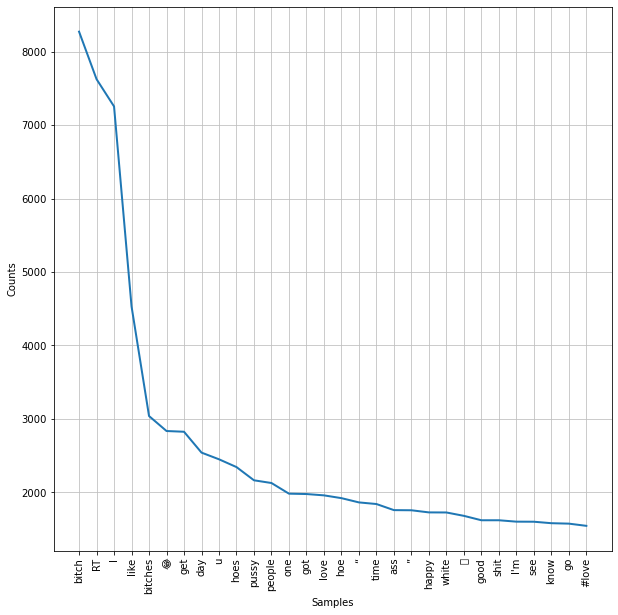

In [259]:
fdist = FreqDist(word_list)
plt.figure(figsize=(10, 10))
fdist.plot(30);

In [260]:
word_list[300:350]

['finally',
 'finish',
 'book',
 'working',
 'awhile',
 '#bookworm',
 '#ontothenextnovel',
 'yup',
 'knicks',
 'fan',
 'hard',
 'easier',
 'nba',
 'fan',
 'playoffs',
 'roll',
 'around',
 'life',
 'social',
 'networking',
 'embrace',
 'day',
 'mom',
 'shares',
 'bihday',
 'bihday',
 'snake',
 'see',
 'weekend',
 'lovely',
 'echeveria',
 'blooms',
 '#flowers',
 '#grow',
 '#gardening',
 '#iphonesia',
 '#bliss',
 '#blooms',
 '#basilicabotanica',
 'amazing',
 '#i_am',
 '#positive',
 '#affirmation',
 '#model',
 'love',
 'u',
 'take',
 'u',
 'time',
 '#whenever']

### Word Frequency Chart for Hate Tweets

In [261]:
hate_word_list = []
for tweet in df[df['label'] == 1]['tweet'].values:
    words = tweet_token.tokenize(tweet)
    for word in words:
        hate_word_list.append(word)

In [162]:
df[df['label'] == 1]['tweet'].values

"@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot  "

In [262]:
hate_word_list = [word for word in hate_word_list if word not in sw]
hate_word_list = [word for word in hate_word_list if word not in list(string.punctuation)]

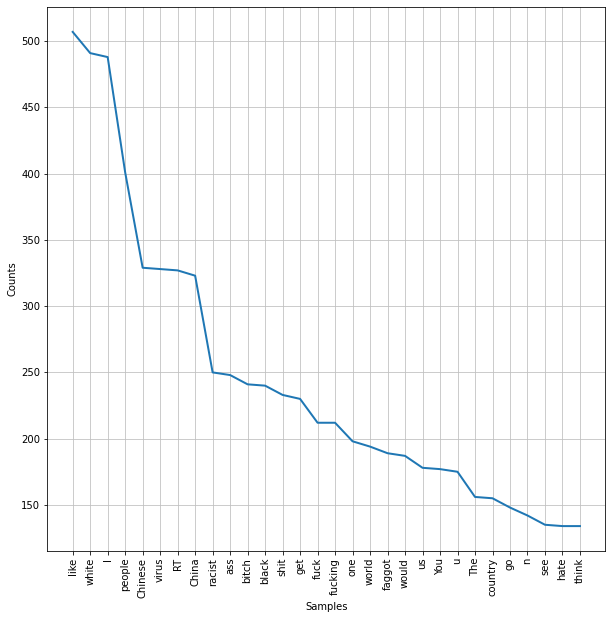

In [263]:
fdist_2 = FreqDist(hate_word_list)
plt.figure(figsize=(10, 10))
fdist_2.plot(30);

In [264]:
hate_word_list[600:650]

['#oppressors',
 '#privileged',
 'latest',
 'volatile',
 'daily',
 'thanks',
 '#space',
 'radicalism',
 'countered',
 'terrorists',
 'see',
 'us',
 'inhumans',
 'free',
 "can't",
 'judge',
 'color',
 'look',
 'passionate',
 '#ivankatrump',
 'plane',
 '#fake',
 'yet',
 'ignore',
 '#adamsaleh',
 '#raâ',
 'todays',
 'donkey',
 '#zionazi',
 'proud',
 'murdering',
 'real',
 'palestinian',
 'semitic',
 'children',
 'thats',
 'callâ',
 'fn',
 'seeking',
 'rid',
 'anti-semitic',
 'xenophobic',
 'image',
 'majority',
 'sympathisers',
 'still',
 'describe',
 'theâ',
 'happy',
 '¨']

## Modeling Results

### Simple Dummy Model (Picks The Majority Class Each Time):

- Training Overall Accuracy: 91.49%
- Cross-Validation Scores: 91.49%, 91.50%, 91.50%, 91.50%, 91.50%
- Testing Overall Accuracy: 91.50%
- AUC for ROC Curve: 0.50
- precision for not hate speech: 91%
- precision for hate speech: 0%
- recall for not hate speech: 100%
- recall for hate speech: 0%
- f1-score for not hate speech: 96%
- f1-score for hate speech: 0%

Overall Conclusion on this model: This simple dummy model simply picks the majority class each time. This allows us to have something to compare our models to.

### KNN Using TF-IDF on Entire Training Set:

- Training Overall Accuracy: 99.97%
- Cross-Validation Scores: 92.50%, 92.50%, 92.36%, 92.45% , 92.50%
- Testing Overall Accuracy: 92.53%
- AUC for ROC Curve: 0.60
- precision for not hate speech: 93%
- precision for hate speech: 89%
- recall for not hate speech: 100%
- recall for hate speech 15%
- f1-score for not hate speech 96%
- f1-score for hate speech 25% 

Overall Conclusion on this model: Not good. The numbers look mostly impressive but a closer look reveals that it is classifying most of the tweets as not hate speech and that it does accurately predict some hate tweets but badly

### KNN Using Count Vectorizer on Entire Training Set:

- Training Overall Accuracy: 99.97%
- Cross-Validation Scores: 92.62%, 92.54%, 92.55%, 92.55%, 92.63%
- Testing Overall Accuracy: 92.60%
- AUC for ROC Curve: 0.66
- precision for not hate speech: 93%
- precision for hate speech: 75%
- recall for not hate speech: 99%
- recall for hate speech: 21%
- f1-score for not hate speech: 96%
- f1-score for hate speech: 32%

Overall Conclusion on this model: Only slightly better then the above KNN model but still pretty bad. The numbers look mostly impressive again but it is still classifying most of the tweets as not hate speech and does a poor job capturing the actual hate speech. 

#### Neither KNN Model is particularly good. Let's move on!

### Naive Bayes (Gaussian) Using TF-IDF on Validation Set:

#### *The Gaussian Model Could Not Be Ran On The Entire Training Set Without Crashing The Notebook and Kernel. The model was ran on the validation set instead which is 80% of the Training Set

- Training Overall Accuracy: 81.90%
- Cross-Validation Scores: *Cross Validation Tests Crashed The Notebook on NB Models*
- Testing Overall Accuracy: 65.03%
- AUC for ROC Curve: 0.62 
- precision for not hate speech: 95%
- precision for hate speech: 13%
- recall for not hate speech: 66%
- recall for hate speech: 58%
- f1-score for not hate speech: 77%
- f1-score for hate speech: 22%

Overall Conclusion on this model: Different weakness but made a LOT of mistakes in classifying both hate and not hate

### Naive Bayes (Gaussian) Using Count Vectorizer on Validation Set:

#### *The Gaussian Model Could Not Be Ran On The Entire Training Set Without Crashing The Notebook and Kernel. The model was ran on the validation set instead which is 80% of the Training Set

- Training Overall Accuracy: 81.90%
- Cross-Validation Scores: *Cross Validation Tests Crashed The Notebook on NB Models*
- Testing Overall Accuracy: 65.11%
- AUC for ROC Curve: 0.62 
- precision for not hate speech: 95%
- precision for hate speech: 14%
- recall for not hate speech: 66%
- recall for hate speech: 59%
- f1-score for not hate speech: 78%
- f1-score for hate speech: 22%

Overall Conclusion on this model: Only slightly different from the above NB model. Not a good model

#### In some ways, the Naive Bayes models do better then the KNN models but in many other ways, they perform worst. Not really worth it. Let's move on

### Multinomial Bayes Using TF-IDF on Entire Training Set:

- Training Overall Accuracy: 92.13%
- Cross-Validation Scores: *Cross Validation Tests Crashed The Notebook on NB Models*
- Testing Overall Accuracy: 91.79%
- AUC for ROC Curve: 0.81
- precision for not hate speech: 92%
- precision for hate speech: 96%
- recall for not hate speech: 100%
- recall for hate speech: 4%
- f1-score for not hate speech: 96%
- f1-score for hate speech: 8%

Overall Conclusion on this model: In some ways, a lot better then the Gaussian NB models but similar to the KNN, it is classifying most of the tweets as non-hate

### Multinomial Bayes Using Count Vectorizer on Entire Training Set:

- Training Overall Accuracy: 94.54%
- Cross-Validation Scores: *Cross Validation Tests Crashed The Notebook on NB Models*
- Testing Overall Accuracy: 92.86%
- AUC for ROC Curve: 0.84
- precision for not hate speech: 94%
- precision for hate speech: 69%
- recall for not hate speech: 99%
- recall for hate speech: 30%
- f1-score for not hate speech: 96%
- f1-score for hate speech: 42%

Overall Conclusion on this model: This is still not a particularly fantastic model BUT it does outperform all of the above models in its ability to classify hate speech. Still feels like we can do better

#### Our Multinomial Bayes models feel like they are our highest performing models thus far. It's not by much though and they're still not fantastic. Let's move on

## Logistic Regression Using TF-IDF on Entire Training Set:

- Training Overall Accuracy: 97.49%
- Cross-Validation Scores: 93.44%, 93.31%, 93.35%, 93.43%, 9331%
- Testing Overall Accuracy: 93.38%
- AUC for ROC Curve: 0.90
- precision for not hate speech: 95%
- precision for hate speech: 70%
- recall for not hate speech: 98%
- recall for hate speech: 40%
- f1-score for not hate speech: 96%
- f1-score for hate speech: 51%

Overall Conclusion on this model: Outperforms the multinomial model. Still not particularly amazing but we're slowly getting better and better

## Logistic Regression Using Count Vectorizer on Entire Training Set:

- Training Overall Accuracy: 96.45%
- Cross-Validation Scores: 93.22%, 93.18%, 93.15%, 93.12%, 93.29%
- Testing Overall Accuracy: 93.16%
- AUC for ROC Curve: 0.90
- precision for not hate speech: 94%
- precision for hate speech: 71%
- recall for not hate speech: 99%
- recall for hate speech: 34%
- f1-score for not hate speech: 96% 
- f1-score for hate speech: 46%

Overall Conclusion on this model: Also quite better then the multinomial models! A little difficult to tell which Logistic Regression model is better since their performance is so close

#### Our new logistic regression models are now our highest performing models since they beat the multinomial models by quite a bit. Still could use some improvement however